In [4]:
import os
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from glob import glob
import pyvista
import mne
import os.path as op

# Add rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

## Visualize averaged time series from individual regions

In [8]:
# # Define base_repo as one level up from current directory
base_repo = op.dirname(op.abspath(''))
plot_dir = f"{base_repo}/data_visualization/plots/"

def parse_subject_CSV(filename):
    # Read in the CSV file
    subject_data = pd.read_csv(filename)

    # Extract subject_ID from filename base name
    subject_ID = os.path.basename(filename).split("_")[0]

    # Add subject_ID to the dataframe
    subject_data["subject_ID"] = subject_ID
    
    # Return the subject data
    return(subject_data)

# Iterate over all the files in MEG_time_series with glob
All_MEG_time_series = pd.concat([parse_subject_CSV(f) for f in glob(f"{base_repo}/data/empirical/MEG_time_series/*_ses-1_meg_1000ms_all_time_series.csv")])

In [7]:
# Find the mean time series for each region
VIS_full_relevant_TS = All_MEG_time_series.query("relevance_type == 'Relevant non-target'")[['subject_ID', 'times', 'V1_V2', 'stimulus_type', 'relevance_type']].groupby('times')['V1_V2'].mean()
PFC_full_relevant_TS = All_MEG_time_series.query("relevance_type == 'Relevant non-target'")[['subject_ID', 'times', 'Prefrontal_Cortex', 'stimulus_type', 'relevance_type']].groupby('times')['Prefrontal_Cortex'].mean()
CS_full_relevant_TS = All_MEG_time_series.query("relevance_type == 'Relevant non-target'")[['subject_ID', 'times', 'Category_Selective', 'stimulus_type', 'relevance_type']].groupby('times')['Category_Selective'].mean()
all_relevant_TS_df = pd.DataFrame({'times': VIS_full_relevant_TS.index, 'V1_V2': VIS_full_relevant_TS.values, 'Prefrontal_Cortex': PFC_full_relevant_TS.values, 'Category_Selective': CS_full_relevant_TS.values})

# sub-CA114 has a particularly pronounced V1/V2 offset spike
VIS_full_relevant_TS_CA114 = All_MEG_time_series.query("relevance_type == 'Relevant non-target'")[['subject_ID', 'times', 'V1_V2', 'stimulus_type', 'relevance_type']].query("subject_ID == 'sub-CA114'").groupby(['times'])['V1_V2'].mean().reset_index()
CS_full_relevant_TS_CA114 = All_MEG_time_series.query("relevance_type == 'Relevant non-target'")[['subject_ID', 'times', 'Category_Selective', 'stimulus_type', 'relevance_type']].query("subject_ID == 'sub-CA114'").groupby(['times'])['Category_Selective'].mean().reset_index()
PFC_full_relevant_TS_CA114 = All_MEG_time_series.query("relevance_type == 'Relevant non-target'")[['subject_ID', 'times', 'Prefrontal_Cortex', 'stimulus_type', 'relevance_type']].query("subject_ID == 'sub-CA114'").groupby(['times'])['Prefrontal_Cortex'].mean().reset_index()
all_CA114_TS_df = pd.DataFrame({'times': VIS_full_relevant_TS_CA114['times'], 'V1_V2': VIS_full_relevant_TS_CA114['V1_V2'], 'Prefrontal_Cortex': PFC_full_relevant_TS_CA114['Prefrontal_Cortex'], 'Category_Selective': CS_full_relevant_TS_CA114['Category_Selective']})

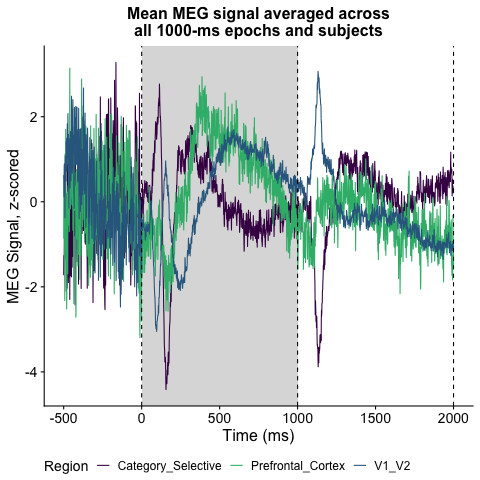

In [9]:
%%R -i all_relevant_TS_df,plot_dir

colors <- viridis::viridis(4)[1:3]

all_relevant_TS_df %>% 
    mutate(segment = case_when(times<0 ~ "Pre-stimulus",
                               times>=0 & times<=1000 ~ "Stimulus",
                               times>1000 ~ "Post-stimulus")) %>%  
    pivot_longer(cols=c(-times, -segment), names_to="Region", values_to="Signal") %>%
    group_by(Region, segment) %>% 
    mutate(Signal_Z = scale(Signal)) %>%
    ggplot(aes(x = times*1000, y = Signal_Z))+
    # scale_x_continuous(expand=c(0,0)) +
    geom_rect(xmin=0, xmax=1000, ymin=-Inf, ymax=Inf, fill="grey85", alpha=0.2) +
    geom_line(aes(color = Region), linewidth=0.5) +
    geom_vline(xintercept=0, linetype="dashed") +
    geom_vline(xintercept=1000, linetype="dashed")  +
    geom_vline(xintercept=2000, linetype="dashed")  +
    ggtitle("Mean MEG signal averaged across\nall 1000-ms epochs and subjects") +
    scale_color_manual(values=c("Category_Selective"=colors[1],
                                "V1_V2"=colors[2],
                                "Prefrontal_Cortex"=colors[3])) +
    xlab("Time (ms)") +
    ylab("MEG Signal, z-scored") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=16),
          legend.position='bottom')
# ggsave(glue("{plot_dir}/methods/All_mean_MEG_signal_full_timecourse.png"), width=6, height=4.25, dpi=300, units='in')

### What if we take the absolute value for each region's averaged time series?

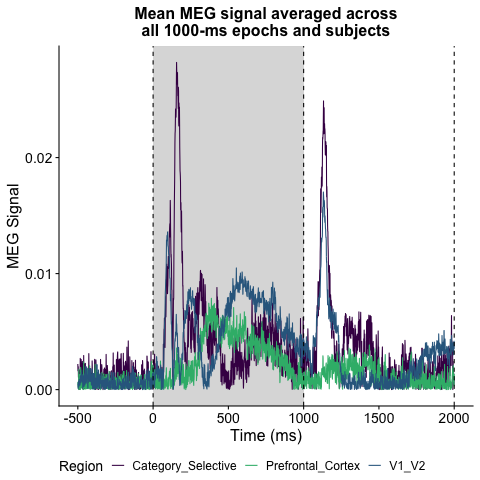

In [10]:
%%R -i all_relevant_TS_df,plot_dir

colors <- viridis::viridis(4)[1:3]

all_relevant_TS_df %>% 
    pivot_longer(cols=c(-times), names_to="Region", values_to="Signal") %>%
    ggplot(aes(x = times*1000, y = abs(Signal)))+
    # scale_x_continuous(expand=c(0,0)) +
    geom_rect(xmin=0, xmax=1000, ymin=-Inf, ymax=Inf, fill="grey85", alpha=0.2) +
    geom_line(aes(color = Region), linewidth=0.5) +
    geom_vline(xintercept=0, linetype="dashed") +
    geom_vline(xintercept=1000, linetype="dashed")  +
    geom_vline(xintercept=2000, linetype="dashed")  +
    ggtitle("Mean MEG signal averaged across\nall 1000-ms epochs and subjects") +
    scale_color_manual(values=c("Category_Selective"=colors[1],
                                "V1_V2"=colors[2],
                                "Prefrontal_Cortex"=colors[3])) +
    xlab("Time (ms)") +
    ylab("MEG Signal") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=16),
          legend.position='bottom')
# ggsave(glue("{plot_dir}/methods/All_mean_MEG_signal_full_timecourse_absval.png"), width=6, height=4.25, dpi=300, units='in')

## Let's make sure that taking the absolute value is supported at the individual level due to opposing VIS/CS dipoles

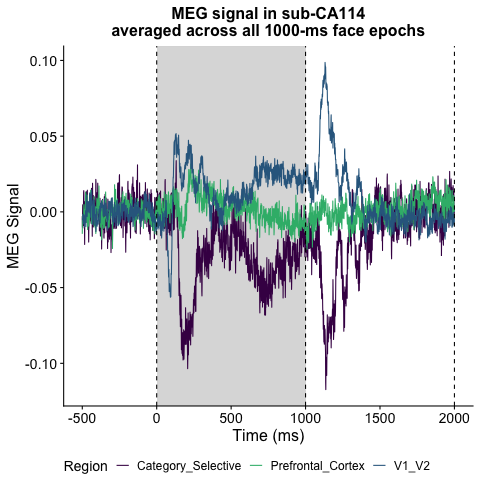

In [30]:
%%R -i all_CA114_TS_df,plot_dir

colors <- viridis::viridis(4)[1:3]

all_CA114_TS_df %>% 
    pivot_longer(cols=c(-times), names_to="Region", values_to="Signal") %>%
    ggplot(aes(x = times*1000, y = Signal))+
    # scale_x_continuous(expand=c(0,0)) +
    geom_rect(xmin=0, xmax=1000, ymin=-Inf, ymax=Inf, fill="grey85", alpha=0.2) +
    geom_line(aes(color = Region), linewidth=0.5) +
    geom_vline(xintercept=0, linetype="dashed") +
    geom_vline(xintercept=1000, linetype="dashed")  +
    geom_vline(xintercept=2000, linetype="dashed")  +
     ggtitle("MEG signal in sub-CA114\naveraged across all 1000-ms face epochs") +
    scale_color_manual(values=c("Category_Selective"=colors[1],
                                "V1_V2"=colors[2],
                                "Prefrontal_Cortex"=colors[3])) +
    xlab("Time (ms)") +
    ylab("MEG Signal") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=16),
          legend.position='bottom')
# ggsave(glue("{plot_dir}/methods/sub-CA114_faces_MEG_signal_full_timecourse.png"), width=6, height=4.1, dpi=300, units='in')

## Dipole visualization with MNE

In [3]:
import numpy as np
import pickle
import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse, make_inverse_operator

data_path = "/path/to/preprocessed/MEG/derivatives"
subjects_dir = f"{data_path}/fs"
subject = "CA114"
epochs = mne.read_epochs(f"{data_path}/preprocessing/sub-{subject}/ses-1/meg/sub-{subject}_ses-1_task-dur_epo.fif", preload=False)

# Get all available event names
event_names = list(epochs.event_id.keys())

# Filter event names containing "face"
matching_events = [e for e in event_names if "face1" in e]

# Load data for the selected events
face_epochs_1000ms = epochs["Duration == '1000ms' & Category=='face'"]
face_epochs_1000ms.load_data().average()

Reading /Users/abry4213/data/Cogitate_MEG/derivatives/preprocessing/sub-CA114/ses-1/meg/sub-CA114_ses-1_task-dur_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Reading /Users/abry4213/data/Cogitate_MEG/derivatives/preprocessing/sub-CA114/ses-1/meg/sub-CA114_ses-1_task-dur_epo-1.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Reading /Users/abry4213/data/Cogitate_MEG/derivatives/preprocessing/sub-CA114/ses-1/meg/sub-CA114_ses-1_task-dur_epo-2.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Reading /Users/abry4213/data/Cogitate_MEG/derivatives/preprocessing/sub-CA114/ses-1/meg/sub-CA114_ses-1_task-dur_epo-3.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata wi

<Evoked | '0.05 × face1 + 0.08 × face2 + 0.07 × face3 + 0.08 × face4 + 0.06 × face5 + 0.05 × face6 + 0.05 × face7 + 0.06 × face8 + 0.08 × face9 + 0.04 × face10 + 0.02 × face11 + 0.06 × face12 + 0.06 × face13 + 0.01 × face14 + 0.03 × face15 + 0.05 × face16 + 0.04 × face17 + 0.07 × face18 + 0.06 × face19 + 0.04 × face20' (average, N=212), -0.5 – 2 s, baseline off, 306 ch, ~6.4 MB>

In [4]:
fwd = mne.read_forward_solution(f"{data_path}/forward/sub-{subject}_ses-1_task-dur_surface_fwd.fif")
mne.convert_forward_solution(fwd, surf_ori=True, copy=False)

# Load noise covariance matrix
with open(f"{data_path}/forward/sub-{subject}_ses-1_task-dur_common_cov.pkl", "rb") as f:
    noise_cov = pickle.load(f)

inv = mne.minimum_norm.make_inverse_operator(face_epochs_1000ms.info, fwd, noise_cov, fixed=True)
lh = fwd["src"][0]  # Visualize the left hemisphere
rh = fwd["src"][1]  # Visualize the right hemisphere

# The vertices of the source space
verts = lh["rr"]
tris = lh["tris"]  # Groups of three vertices that form triangles
dip_pos = lh["rr"][lh["vertno"]]  # The position of the dipoles
dip_ori = lh["nn"][lh["vertno"]]
dip_len = len(dip_pos)
dip_times = [0]
white = (1.0, 1.0, 1.0)  # RGB values for a white color

actual_amp = np.ones(dip_len)  # fake amp, needed to create Dipole instance
actual_gof = np.ones(dip_len)  # fake GOF, needed to create Dipole instance
dipoles = mne.Dipole(dip_times, dip_pos, actual_amp, dip_ori, actual_gof)

# Compute the source estimate for the left auditory condition in the sample
# dataset.
# Compute the evoked response by averaging epochs
evoked_face_1000ms = face_epochs_1000ms.average()
inv = make_inverse_operator(evoked_face_1000ms.info, fwd, noise_cov, fixed=True)
stc = apply_inverse(evoked_face_1000ms, inv, pick_ori=None)

Reading forward solution from /Users/abry4213/data/Cogitate_MEG/derivatives/forward/sub-CA114_ses-1_task-dur_surface_fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (8192 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7601/8192 = 10.001118
    scale = 5.49729e-08 

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_83394/3220389889.py:8: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (75 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(face_epochs_1000ms.info, fwd, noise_cov, fixed=True)
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_83394/3220389889.py:8: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (75 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(face_epochs_1000ms.info, fwd, noise_cov, fixed=True)


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 5.58613
    scaling factor to adjust the trace = 6.6014e+18 (nchan = 306 nzero = 231)
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7601/8192 = 10.001118
    scale = 5.49729e-08 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 5.3e-13 (2.2e-16 eps * 306 dim * 7.7  max singular value)
    Estimated rank (mag + grad): 75
    MEG: rank 75 computed from 306 data channels with 

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_83394/3220389889.py:29: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (75 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = make_inverse_operator(evoked_face_1000ms.info, fwd, noise_cov, fixed=True)
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_83394/3220389889.py:29: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (75 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = make_inverse_operator(evoked_face_1000ms.info, fwd, noise_cov, fixed=True)


    largest singular value = 5.58613
    scaling factor to adjust the trace = 6.6014e+18 (nchan = 306 nzero = 231)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 212
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 75 (231 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.05 × face1 + 0.08 × face2 + 0.07 × face3 + 0.08 × face4 + 0.06 × face5 + 0.05 × face6 + 0.05 × face7 + 0.06 × face8 + 0.08 × face9 + 0.04 × face10 + 0.02 × face11 + 0.06 × face12 + 0.06 × face13 + 0.01 × face14 + 0.03 × face15 + 0.05 × face16 + 0.04 × face17 + 0.07 × face18 + 0.06 × face19 + 0.04 × face20"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  84.0% variance
    dSPM...
[done]

In [6]:
import mne
import pyvistaqt
import matplotlib

# Ensure the correct backend for matplotlib and MNE
matplotlib.use('qt5agg')  # Set to 'qt5agg' for PyQt compatibility
mne.viz.set_3d_backend("pyvistaqt")  # Set the correct MNE 3D backend

# Create the 3D figure
fig = mne.viz.create_3d_figure(size=(600, 400), bgcolor='white')

# Assuming 'stc' and 'subjects_dir' are properly defined in your script
_, time_max = stc.get_peak(hemi="lh")

# Plot the brain surface at the peak time
brain_fixed = stc.plot(
    subject="sub-CA114",
    surface="inflated",
    hemi="both",
    background="white",
    cortex='low_contrast',
    subjects_dir=subjects_dir,
    initial_time=time_max,
    time_unit="s",
    size=(600, 400),
)

# Set the 3D view of the brain at the specified focal point
mne.viz.set_3d_view(figure=brain_fixed, focalpoint=(0.0, 0.0, 50))

# Update and show the figure
fig.plotter.app.processEvents()  # Update the window to include the figure
fig.plotter.show()  # Show the figure


Using pyvistaqt 3d backend.
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Using control points [ 4.13160673  4.78168175 14.75206423]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


2025-03-22 14:48:32.509 python[80726:6987088] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-22 14:48:32.509 python[80726:6987088] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [8]:
# Extract the source activation data at a specific time index
# time_idx = stc.time_as_index(1.123)  # Get index for time = 1.123 sec
# Assuming 'stc' and 'subjects_dir' are properly defined in your script
_, time_max = stc.get_peak(hemi="lh")
time_idx = stc.time_as_index(time_max)  # Get index for time = 0.150 sec

# Activation values at the selected time point
activation_values = stc.data[:, time_idx]

# Save the vertex-wise activation values
np.savetxt("vertex_activation_values.txt", activation_values)

# Corresponding vertex indices
lh_vertices, rh_vertices = stc.vertices

subject="sub-CA114"
# Load Schaefer parcellation for both hemispheres
labels_lh = mne.read_labels_from_annot(
    subject, 
    parc="Schaefer100_7Networks_in_sub-CA114",
    hemi="lh",
    subjects_dir=subjects_dir
)

labels_rh = mne.read_labels_from_annot(
    subject, 
    parc="Schaefer100_7Networks_in_sub-CA114",
    hemi="rh",
    subjects_dir=subjects_dir
)

# Create a dictionary mapping vertex indices to parcel names
parcel_map_left = {}
parcel_map_right = {}

# Compute parcel-wise polarity
# Initialize dictionary to store parcel activations
parcel_activations_left = {}
parcel_activations_right = {}

# Map hemisphere vertices
for label in labels_lh:
    for vertex in label.vertices:
        parcel_map_left[vertex] = label.name
for label in labels_rh:
    for vertex in label.vertices:
        parcel_map_right[vertex] = label.name

for vertex, activation in zip(np.hstack([lh_vertices, rh_vertices]), activation_values):
    parcel_name = parcel_map_left.get(vertex, "Unknown")
    if parcel_name not in parcel_activations_left:
        parcel_activations_left[parcel_name] = []
    parcel_activations_left[parcel_name].append(activation)
for vertex, activation in zip(np.hstack([lh_vertices, rh_vertices]), activation_values):
    parcel_name = parcel_map_right.get(vertex, "Unknown")
    if parcel_name not in parcel_activations_right:
        parcel_activations_right[parcel_name] = []
    parcel_activations_right[parcel_name].append(activation)

# Compute mean polarity per parcel
parcel_polarities_left = {parcel: np.mean(acts) for parcel, acts in parcel_activations_left.items()}
parcel_polarities_right = {parcel: np.mean(acts) for parcel, acts in parcel_activations_right.items()}

# Identify parcels with positive and negative polarity
positive_parcels_left = {p: v for p, v in parcel_polarities_left.items() if v > 0}
negative_parcels_left = {p: v for p, v in parcel_polarities_left.items() if v < 0}
positive_parcels_right = {p: v for p, v in parcel_polarities_right.items() if v > 0}
negative_parcels_right = {p: v for p, v in parcel_polarities_right.items() if v < 0}

positive_df_left = pd.DataFrame(positive_parcels_left.items(), columns=["label", "Activation"]).assign(Hemisphere="Left")
negative_df_left = pd.DataFrame(negative_parcels_left.items(), columns=["label", "Activation"]).assign(Hemisphere="Left")
positive_df_right = pd.DataFrame(positive_parcels_right.items(), columns=["label", "Activation"]).assign(Hemisphere="Right")
negative_df_right = pd.DataFrame(negative_parcels_right.items(), columns=["label", "Activation"]).assign(Hemisphere="Right")
merged_polarity_df = pd.concat([positive_df_left, negative_df_left, positive_df_right, negative_df_right]).reset_index(drop=True)

Reading labels from parcellation...
   read 51 labels from /Users/abry4213/data/Cogitate_MEG/derivatives/fs/sub-CA114/label/lh.Schaefer100_7Networks_in_sub-CA114.annot
Reading labels from parcellation...
   read 51 labels from /Users/abry4213/data/Cogitate_MEG/derivatives/fs/sub-CA114/label/rh.Schaefer100_7Networks_in_sub-CA114.annot


### Plot vertex-wise polarity distributions per region

In [10]:
left_hemisphere_VIS_activations = np.concat([parcel_activations_left['7Networks_LH_Vis_4-lh'], parcel_activations_left['7Networks_LH_Vis_5-lh']])
right_hemisphere_VIS_activations = np.concat([parcel_activations_right['7Networks_RH_Vis_4-rh'], parcel_activations_right['7Networks_RH_Vis_5-rh']])
left_hemisphere_CS_activations = np.array(parcel_activations_left['7Networks_LH_DorsAttn_Post_1-lh'])
right_hemisphere_CS_activations = np.array(parcel_activations_right['7Networks_RH_Vis_3-rh'])

# Dataframe
CS_VIS_activations_df = pd.DataFrame(np.concatenate([left_hemisphere_VIS_activations, right_hemisphere_VIS_activations,
                                                     left_hemisphere_CS_activations, right_hemisphere_CS_activations]), columns=["Activation"])
CS_VIS_activations_df["Region"] = ["VIS"]*len(left_hemisphere_VIS_activations) + ["VIS"]*len(right_hemisphere_VIS_activations) + ["CS"]*len(left_hemisphere_CS_activations) + ["CS"]*len(right_hemisphere_CS_activations)
CS_VIS_activations_df["Hemisphere"] = ["Left"]*len(left_hemisphere_VIS_activations) + ["Right"]*len(right_hemisphere_VIS_activations) + ["Left"]*len(left_hemisphere_CS_activations) + ["Right"]*len(right_hemisphere_CS_activations)

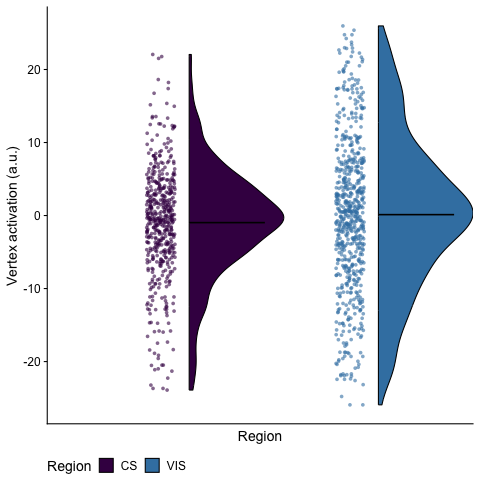

In [27]:
%%R -i CS_VIS_activations_df,plot_dir

CS_VIS_activations_df %>%
    ggplot(mapping=aes(x=Region, y=Activation, fill=Region)) +
    geom_violinhalf(scale="width", color="black", position = position_nudge(x = 0.15), width=1)  +
    geom_point(aes(color = Region), position = position_jitter(width = 0.075, height=0),
                            size = 1.75, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.4, linewidth=0.3, 
            show.legend=FALSE, position = position_nudge(x=0.35)) +
    facet_wrap(Hemisphere ~ .) +
    ylab("Vertex activation (a.u.)") +
    scale_fill_manual(values=c("CS"="#410151", "VIS"="#3d81b1")) +
    scale_color_manual(values=c("CS"="#410151", "VIS"="#3d81b1")) +
    theme(strip.background = element_blank(),
          legend.position='bottom',
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank())
# ggsave(glue('{plot_dir}/methods/sub-CA114_CS_VIS_vertex_activations.svg'), width=4, height=4, units='in', dpi=300)